In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from numpy.random import normal
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-darkgrid')

In [2]:
data = pd.read_csv('covid_19_clean_complete.csv', parse_dates=['Date'])

In [3]:
def create_country_df(country, end_date = '2020-06-28'):
  df = data.loc[data['Country/Region'] == country, ["Country/Region", "Date", "Confirmed", "Deaths", "Recovered"]]
  df.columns = ['country', 'date', 'confirmed', 'deaths', 'recovered']

  df.groupby(['country', 'date'])['confirmed', 'deaths', 'recovered'].sum().reset_index()
  df.date = pd.to_datetime(df.date)
  df = df.sort_values(by='date')
  df = df[df.date <= end_date]

  # create daily cases
  day_before = np.array([0]+list(df['confirmed'][:-1]))
  daily_confirmed = np.array(df['confirmed']) - day_before
  df['daily_confirmed'] = daily_confirmed

  # create rolling mean
  df['rolling_mean'] = df['daily_confirmed'].rolling(window=4).mean()

  # create log of daily cases
  start_date = df['date'].min()
  df['days_since_start'] = df['date'] - start_date
  df['days_since_start'] = df['days_since_start'].dt.days.astype(int)
  df['log_daily_confirmed'] = np.log1p(df['daily_confirmed'])

  # view confirmed cases
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
  sns.lineplot(x=df.date, y=df.daily_confirmed, ax=ax1)
  ax1.set(ylabel='Daily Confirmed Cases', xlabel='Date',
          title=f'Daily New Confirmed Cases in {country}')
  sns.lineplot(x=df.date, y=df.confirmed, ax=ax2)
  ax2.set(ylabel='Cumulative Confirmed Cases', xlabel='Date',
          title=f'Cumulative Total Confirmed Cases in {country}')
  
  return df

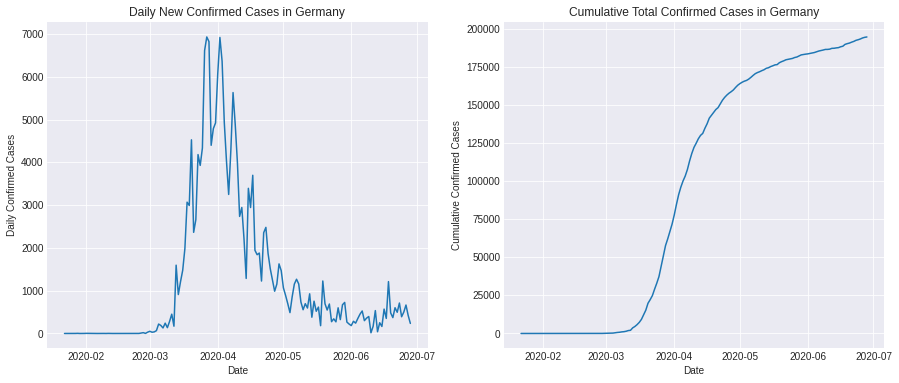

In [4]:
ger = create_country_df('Germany')

In [5]:
def plot_log_cases(df, country_name, start=0, end=-1):
  plt.figure(figsize=(12, 7))
  ax = sns.scatterplot(x=df['days_since_start'].iloc[start:end], y=df['log_daily_confirmed'].iloc[start:end])
  min_date = df['date'].iloc[0].date()
  start_date = df['date'].iloc[start].date()
  end_date = df['date'].iloc[end].date()
  ax.set(ylabel='Log of daily new cases', xlabel=f'Days since {min_date}',
          title=f'Log Daily confirmed cases: {country_name} from {start_date} to {end_date}')

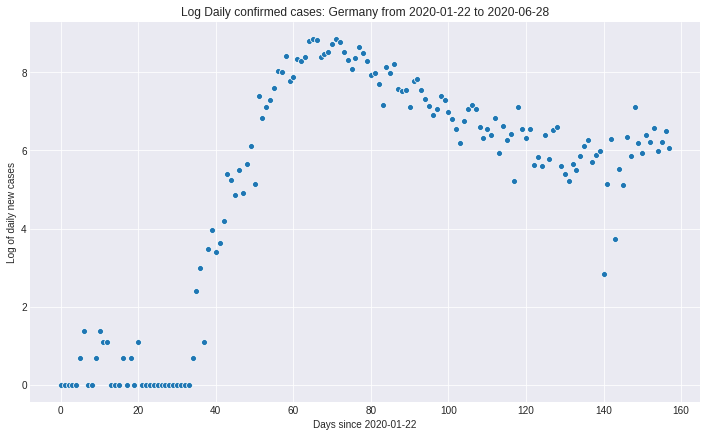

In [6]:
plot_log_cases(ger, 'Germany')

In [7]:
def create_k_model(df, k, start=0, end=-1):
  x = df['days_since_start'][start:end]
  y = df['log_daily_confirmed'].iloc[start:end]

  with pm.Model() as model:
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)

    # switchpoint array
    s_arr = []
    s_testvals = x.quantile(q=[i/k for i in range(1, k)]).values
    for i in range(k-1):
      s_arr.append(
          pm.DiscreteUniform(
              f's{i+1}',
              lower = x.iloc[0] if not s_arr else s_arr[-1], 
              upper = x.iloc[-1], testval = s_testvals[i]))

    # priors for the pre and post switch intercepts and gradients
    w_arr = []
    b_arr = []
    for i in range(k):
      w_arr.append(pm.Uniform(f'w{i+1}', lower=-10, upper=10))
      b_arr.append(pm.Normal(f'b{i+1}', 0, sd=20))
    
    w_switch_arr = []
    b_switch_arr = []
    for i in range(k-1):
      w_switch_arr.append(
          pm.math.switch(
              s_arr[-(i+1)] < x,
              w_arr[-1] if not w_switch_arr else w_switch_arr[-1],
              w_arr[-(i+2)]))
      b_switch_arr.append(
          pm.math.switch(
              s_arr[-(i+1)] < x,
              b_arr[-1] if not b_switch_arr else b_switch_arr[-1],
              b_arr[-(i+2)]))
    
    likelihood = pm.Normal(
        'y', mu = w_switch_arr[-1] * x + b_switch_arr[-1], sd=sigma, observed=y)

    start = pm.find_MAP()
    nuts_arr = [sigma]
    for i in range(k):
      nuts_arr.append(b_arr[i])
      nuts_arr.append(w_arr[i])

    step1 = pm.NUTS(nuts_arr)
    step2 = pm.Metropolis(s_arr)
    trace = pm.sample(
        20000, tune=1000, step=[step1, step2], 
        start=start, chains=2, progressbar=True, cores=2)
    return trace

In [21]:
def get_y(x, s, b, w, std=0.1):
  x = np.array(x)
  y = np.zeros(shape=x.shape)
  switch_idx = 0
  for i in range(len(y)):
    if switch_idx < len(s) and x[i] >= s[switch_idx]:
      switch_idx += 1
    y[i] = x[i] * w[switch_idx] + b[switch_idx] + normal(0, std, 1)
  return y 

def get_pred(samples, burn_in=5000):
  return samples[burn_in:].mean()

def get_confidence_intervals(sigma_samples, y_fit, alpha=0.9):
  y_fit = np.array(y_fit)
  sigma_mean = sigma_samples[5000:].mean()
  y_samples = np.zeros(shape=(len(y_fit), 100))
  for i in range(len(y_fit)):
      y_samples[i, :] = np.random.normal(y_fit[i], sigma_mean, 100)
      y_samples[i, :] = sorted(y_samples[i, :])
  low = int((1-alpha) * 100/2)
  high = 100-low 
  credible_intervals = [(y_samples[i, low], y_samples[i, high]) for i in range(len(y_fit))]
  lower_bounds = [low for low, _ in credible_intervals]
  upper_bounds = [high for _, high in credible_intervals]
  return lower_bounds, upper_bounds

In [22]:
def plot_extrapolation_4(df, trace, start=0, end=-1, days_after=30, burn_in=5000):
  # define x and y
  x = df['days_since_start'][start:end]
  y = df['log_daily_confirmed'].iloc[start:end]

  # get expected values
  w_preds = [get_pred(w, burn_in) for w in [trace['w1'], trace['w2'], trace['w3'], trace['w4']]]
  b_preds = [get_pred(b, burn_in) for b in [trace['b1'], trace['b2'], trace['b3'], trace['b4']]]
  s_preds = [int(round(get_pred(s, burn_in))) for s in [trace['s1'], trace['s2'], trace['s3']]]
  sigma_samples = trace['sigma'][burn_in:]

  # define y_fit
  y_fit = get_y(x, s_preds, b_preds, w_preds, std=0)

  # define 90% credible intervals for data
  lower_bounds, upper_bounds = get_confidence_intervals(sigma_samples, y_fit)

  # define 90% credible intervals for extrapolation
  last_day = df['date'].iloc[end-1]
  x_after = np.linspace(x.iloc[-1], x.iloc[-1]+days_after, days_after+1)
  dates_after = np.array([last_day + timedelta(days=x) for x in range(days_after+1)])
  y_fit_pred = b_preds[-1] + w_preds[-1] * x_after
  pred_lower_bounds, pred_upper_bounds = get_confidence_intervals(sigma_samples, y_fit_pred)

  # Plot the original and extrapolation
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
  sns.lineplot(x, y_fit, color='orange', label='y fit from posterior means',
              ax=ax1)
  sns.scatterplot(df['days_since_start'], df['log_daily_confirmed'], label='Actual y', ax=ax1)
  sns.lineplot(x_after, y_fit_pred, color='r', label='Extrapolated y fit', ax=ax1)
  ax1.fill_between(x, lower_bounds, upper_bounds, alpha=0.5,
                  label='90% credible simulated y')
  ax1.fill_between(x_after, pred_lower_bounds, pred_upper_bounds, alpha=0.5,
                  color='r', label='Extrapolated 90% credible simulated y')
  ymin, ymax = ax1.get_ylim()
  ax1.vlines(s_preds[0], ymin, ymax, linestyle="--", 
            label="Switchpoint 1")
  ax1.vlines(s_preds[1], ymin, ymax, linestyle="--", 
            label="Switchpoint 2")
  ax1.vlines(s_preds[2], ymin, ymax, linestyle="--", 
            label="Switchpoint 3")
  ax1.set(xlabel='Days since 2020-01-22', ylabel='Log of Daily Confirmed',
          title=f'Log of daily confirmed with switchpoint at x = {s_preds[0]}, {s_preds[1]}, {s_preds[2]}')
  ax1.legend(loc='lower right')

  sns.lineplot(df['date'], df['daily_confirmed'],
                  label='Daily confirmed', ax=ax2)
  sns.lineplot(df['date'], df['rolling_mean'], label='Rolling mean', ax=ax2)
  ax2.fill_between(df['date'][start:end], np.exp(lower_bounds), np.exp(upper_bounds), 
                    alpha=0.5, label='90% credible simulated y')
  ax2.fill_between(dates_after, np.exp(pred_lower_bounds), np.exp(pred_upper_bounds),
                  alpha=0.5, color='r', label='Extrapolated 90% credible simulated y')
  ymin, ymax = ax2.get_ylim()
  ax2.vlines(df['date'].iloc[0]+timedelta(days=int(s_preds[0])), ymin, ymax, linestyle="--",
            label="Switchpoint 1")
  ax2.vlines(df['date'].iloc[0]+timedelta(days=int(s_preds[1])), ymin, ymax, linestyle="--",
            label="Switchpoint 2")
  ax2.vlines(df['date'].iloc[0]+timedelta(days=int(s_preds[2])), ymin, ymax, linestyle="--",
            label="Switchpoint 3")
  switch_date_1 = df['date'].iloc[0]+timedelta(days=int(s_preds[0]))
  switch_date_2 = df['date'].iloc[0]+timedelta(days=int(s_preds[1]))
  switch_date_3 = df['date'].iloc[0]+timedelta(days=int(s_preds[2]))
  ax2.set(xlim=[df['date'].iloc[0], dates_after[-1]], xlabel='Date', ylabel='Daily Confirmed',
          title=f'Daily confirmed graph with switchpoint at {switch_date_1.date()}, {switch_date_2.date()} and {switch_date_3.date()}')
  ax2.legend(loc='upper right')

In [10]:
k = 4
ger_trace_4 = create_k_model(ger, k)

logp = -219.82, ||grad|| = 1.3128: 100%|██████████| 153/153 [00:00<00:00, 1066.86it/s] 
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [w4, b4, w3, b3, w2, b2, w1, b1, sigma]
>CompoundStep
>>Metropolis: [s3]
>>Metropolis: [s2]
>>Metropolis: [s1]
Sampling 2 chains: 100%|██████████| 42000/42000 [13:30<00:00, 51.83draws/s]
There were 10757 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.15971076335576262, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8903383225714536, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


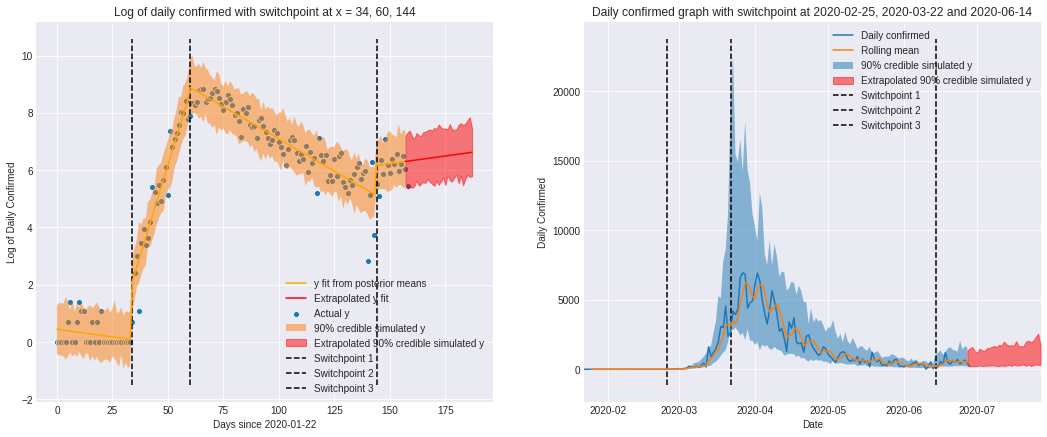

In [16]:
plot_extrapolation_4(ger, ger_trace_4)

In [45]:
def plot_extrapolation(df, trace, k=4, start=0, end=-1, days_after=30, burn_in=5000):
  # define x and y
  x = df['days_since_start'][start:end]
  y = df['log_daily_confirmed'].iloc[start:end]

  # get expected values
  w_preds = [get_pred(w, burn_in) for w in [trace[f'w{i+1}'] for i in range(k)]]
  b_preds = [get_pred(b, burn_in) for b in [trace[f'b{i+1}'] for i in range(k)]]
  s_preds = [int(round(get_pred(s, burn_in))) for s in [trace[f's{i+1}'] for i in range(k-1)]]
  sigma_samples = trace['sigma'][burn_in:]

  # define y_fit
  y_fit = get_y(x, s_preds, b_preds, w_preds, std=0)

  # define 90% credible intervals for data
  lower_bounds, upper_bounds = get_confidence_intervals(sigma_samples, y_fit)

  # define 90% credible intervals for extrapolation
  last_day = df['date'].iloc[end-1]
  x_after = np.linspace(x.iloc[-1], x.iloc[-1]+days_after, days_after+1)
  dates_after = np.array([last_day + timedelta(days=x) for x in range(days_after+1)])
  y_fit_pred = b_preds[-1] + w_preds[-1] * x_after
  pred_lower_bounds, pred_upper_bounds = get_confidence_intervals(sigma_samples, y_fit_pred)

  # Plot the original and extrapolation
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
  sns.lineplot(x, y_fit, color='orange', label='y fit from posterior means',
              ax=ax1)
  sns.scatterplot(df['days_since_start'], df['log_daily_confirmed'], label='Actual y', ax=ax1)
  sns.lineplot(x_after, y_fit_pred, color='r', label='Extrapolated y fit', ax=ax1)
  ax1.fill_between(x, lower_bounds, upper_bounds, alpha=0.5,
                  label='90% credible simulated y')
  ax1.fill_between(x_after, pred_lower_bounds, pred_upper_bounds, alpha=0.5,
                  color='r', label='Extrapolated 90% credible simulated y')
  ymin, ymax = ax1.get_ylim()
  for i in range(k-1):
    ax1.vlines(s_preds[i], ymin, ymax, linestyle='--', label=f'Switchpoint at x = {s_preds[i]}')
  ax1.set(xlabel='Days since 2020-01-22', ylabel='Log of Daily Confirmed',
          title=f'Log of daily confirmed with {k-1} switchpoints')
  ax1.legend(loc='best')

  sns.lineplot(df['date'], df['daily_confirmed'],
                  label='Daily confirmed', ax=ax2)
  sns.lineplot(df['date'], df['rolling_mean'], label='Rolling mean', ax=ax2)
  ax2.fill_between(df['date'][start:end], np.exp(lower_bounds), np.exp(upper_bounds), 
                    alpha=0.5, label='90% credible simulated y')
  ax2.fill_between(dates_after, np.exp(pred_lower_bounds), np.exp(pred_upper_bounds),
                  alpha=0.5, color='r', label='Extrapolated 90% credible simulated y')
  ymin, ymax = ax2.get_ylim()
  switch_dates = []
  for i in range(k-1):
    switch_date = df['date'].iloc[0]+timedelta(days=s_preds[i])
    ax2.vlines(switch_date, ymin, ymax, linestyle='--',
               label=f'Switchpoint at {switch_date.date()}')
  ax2.set(xlim=[df['date'].iloc[0], dates_after[-1]], xlabel='Date',
          ylabel='Daily Confirmed', title=f'Daily confirmed graph with {k-1} switchpoints')
  ax2.legend(loc='best')

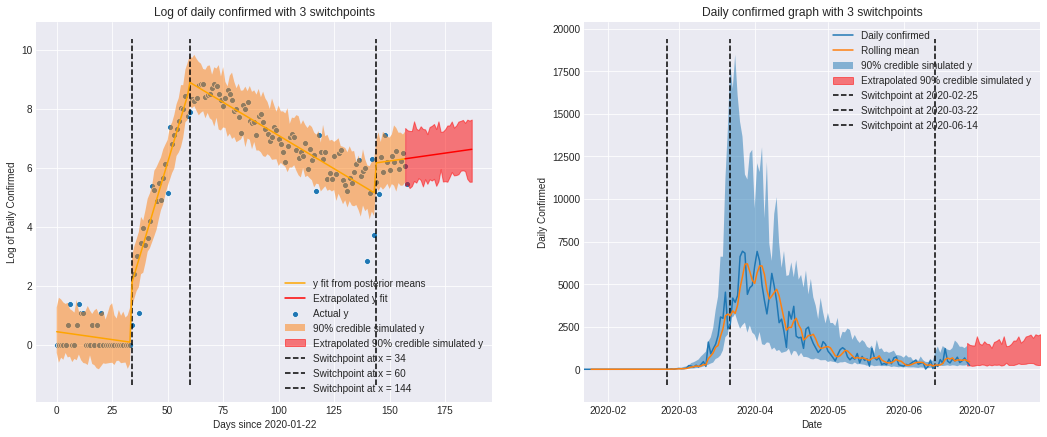

In [46]:
plot_extrapolation(ger, ger_trace_4)

In [52]:
def plot_posterior(trace, k, burn_in=5000):
  num_plots = 2 * k + (k-1) + 1
  fig, axs = plt.subplots(nrows=num_plots, ncols=1, figsize=(15, 3 * num_plots))
  ax_idx = 0
  for i in range(k):
    axs[ax_idx].hist(trace[f'w{i+1}'][burn_in:], histtype='stepfilled', 
                     bins=25, alpha=0.85, label=f"posterior of $w{i+1}$",
                     color="red", density=True)
    axs[ax_idx].legend(loc='upper right')
    ax_idx += 1
    axs[ax_idx].hist(trace[f'b{i+1}'][burn_in:], histtype='stepfilled', 
                     bins=25, alpha=0.85, label=f"posterior of $b{i+1}$",
                     color="blue", density=True)
    axs[ax_idx].legend(loc='upper right')
    ax_idx += 1
  for i in range(k-1):
    axs[ax_idx].hist(trace[f's{i+1}'][burn_in:], histtype='stepfilled', 
                     bins=25, alpha=0.85, label=f"posterior of $s{i+1}$",
                     color="green", density=True)
    axs[ax_idx].legend(loc='upper right')
    ax_idx += 1
  axs[ax_idx].hist(trace['sigma'][burn_in:], histtype='stepfilled', 
                     bins=25, alpha=0.85, label="posterior of $sigma$",
                     color="yellow", density=True)
  axs[ax_idx].legend(loc='upper right')


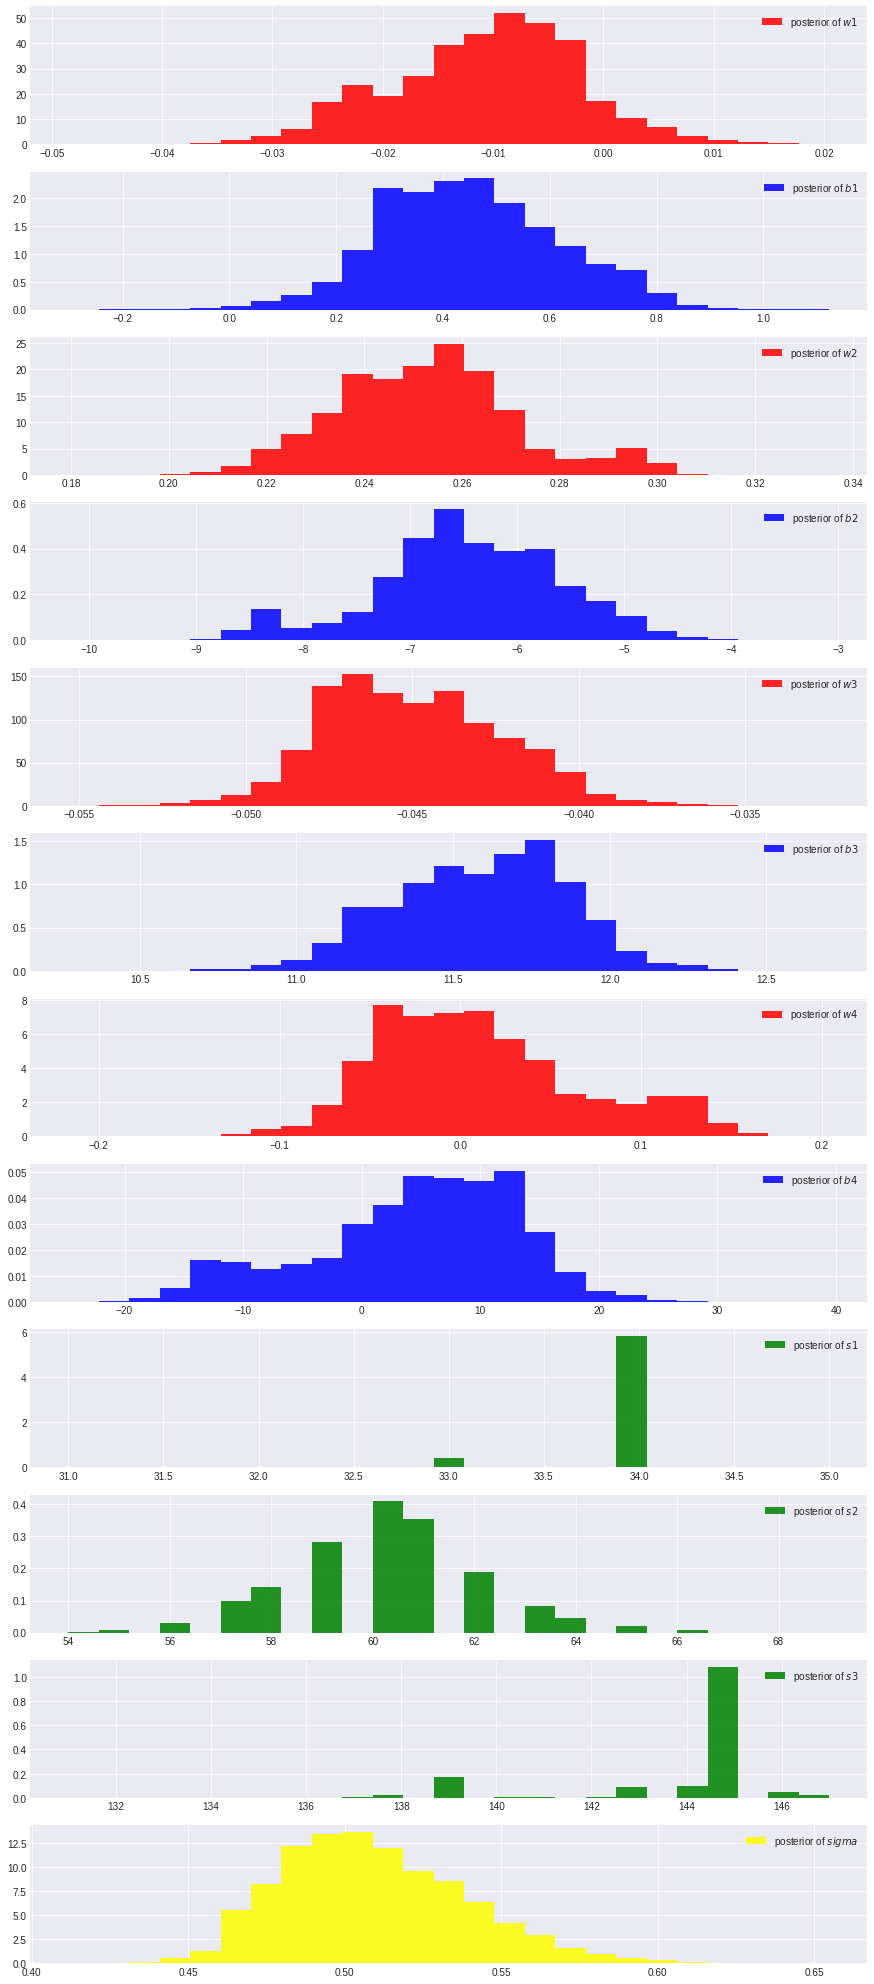

In [53]:
plot_posterior(ger_trace_4, 4)

In [73]:
# Combine logic into a class

class KSegmentsModel:
  def __init__(self, data, country_name):
    self.country_name = country_name
    self.df = self.create_extra_fields(data)
    self.k = 2
    self.start = 0
    self.end = -1
    self.trace = None

  def create_extra_fields(self, data):
    df = data.loc[data['Country/Region'] == self.country_name,
                  ["Country/Region", "Date", "Confirmed", "Deaths", "Recovered"]]
    df.columns = ['country', 'date', 'confirmed', 'deaths', 'recovered']

    df.groupby(['country', 'date'])['confirmed', 'deaths', 'recovered'].sum().reset_index()
    df.date = pd.to_datetime(df.date)
    df = df.sort_values(by='date')

    # create daily cases
    day_before = np.array([0]+list(df['confirmed'][:-1]))
    daily_confirmed = np.array(df['confirmed']) - day_before
    df['daily_confirmed'] = daily_confirmed

    # create rolling mean
    df['rolling_mean'] = df['daily_confirmed'].rolling(window=4).mean()

    # create log of daily cases
    start_date = df['date'].min()
    df['days_since_start'] = df['date'] - start_date
    df['days_since_start'] = df['days_since_start'].dt.days.astype(int)
    df['log_daily_confirmed'] = np.log1p(df['daily_confirmed'])

    # view confirmed cases
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    sns.lineplot(x=df.date, y=df.daily_confirmed, ax=ax1)
    ax1.set(ylabel='Daily Confirmed Cases', xlabel='Date',
            title=f'Daily New Confirmed Cases in {self.country_name}')
    sns.lineplot(x=df.date, y=df.confirmed, ax=ax2)
    ax2.set(ylabel='Cumulative Confirmed Cases', xlabel='Date',
            title=f'Cumulative Total Confirmed Cases in {self.country_name}')
    
    return df

  def plot_log(self, start=0, end=-1):
    plt.figure(figsize=(12, 7))
    ax = sns.scatterplot(
        x=self.df['days_since_start'].iloc[start:end],
        y=self.df['log_daily_confirmed'].iloc[start:end])
    min_date = self.df['date'].iloc[0].date()
    start_date = self.df['date'].iloc[start].date()
    end_date = self.df['date'].iloc[end].date()
    ax.set(ylabel='Log of daily new cases', xlabel=f'Days since {min_date}',
            title=f'Log Daily confirmed cases: {self.country_name} from {start_date} to {end_date}')
    return ax
    
  def fit(self, k, start=0, end=-1):
    # Update instance parameters
    self.k = k
    self.start = start
    self.end = end

    x = self.df['days_since_start'][start:end]
    y = self.df['log_daily_confirmed'].iloc[start:end]

    with pm.Model() as model:
      sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)

      # switchpoint array
      s_arr = []
      s_testvals = x.quantile(q=[i/k for i in range(1, k)]).values
      for i in range(k-1):
        s_arr.append(
            pm.DiscreteUniform(
                f's{i+1}',
                lower = x.iloc[0] if not s_arr else s_arr[-1], 
                upper = x.iloc[-1], testval = s_testvals[i]))

      # priors for the pre and post switch intercepts and gradients
      w_arr = []
      b_arr = []
      for i in range(k):
        w_arr.append(pm.Uniform(f'w{i+1}', lower=-10, upper=10))
        b_arr.append(pm.Normal(f'b{i+1}', 0, sd=20))
      
      w_switch_arr = []
      b_switch_arr = []
      for i in range(k-1):
        w_switch_arr.append(
            pm.math.switch(
                s_arr[-(i+1)] < x,
                w_arr[-1] if not w_switch_arr else w_switch_arr[-1],
                w_arr[-(i+2)]))
        b_switch_arr.append(
            pm.math.switch(
                s_arr[-(i+1)] < x,
                b_arr[-1] if not b_switch_arr else b_switch_arr[-1],
                b_arr[-(i+2)]))
      
      likelihood = pm.Normal(
          'y', mu = w_switch_arr[-1] * x + b_switch_arr[-1], sd=sigma, observed=y)

      start = pm.find_MAP()
      nuts_arr = [sigma]
      for i in range(k):
        nuts_arr.append(b_arr[i])
        nuts_arr.append(w_arr[i])

      step1 = pm.NUTS(nuts_arr)
      step2 = pm.Metropolis(s_arr)
      trace = pm.sample(
          20000, tune=1000, step=[step1, step2], 
          start=start, chains=2, progressbar=True, cores=2)
      
      # Update trace
      self.trace = trace
      return trace

  def plot_posterior(self, burn_in=5000):
    # define parameters
    t = self.trace
    k = self.k
    num_plots = 2 * k + (k-1) + 1
    fig, axs = plt.subplots(nrows=num_plots, ncols=1, figsize=(15, 3 * num_plots))
    ax_idx = 0
    for i in range(k):
      axs[ax_idx].hist(t[f'w{i+1}'][burn_in:], histtype='stepfilled', 
                      bins=25, alpha=0.85, label=f"posterior of $w{i+1}$",
                      color="red", density=True)
      axs[ax_idx].legend(loc='upper right')
      ax_idx += 1
      axs[ax_idx].hist(t[f'b{i+1}'][burn_in:], histtype='stepfilled', 
                      bins=25, alpha=0.85, label=f"posterior of $b{i+1}$",
                      color="blue", density=True)
      axs[ax_idx].legend(loc='upper right')
      ax_idx += 1
    for i in range(k-1):
      axs[ax_idx].hist(t[f's{i+1}'][burn_in:], histtype='stepfilled', 
                      bins=25, alpha=0.85, label=f"posterior of $s{i+1}$",
                      color="green", density=True)
      axs[ax_idx].legend(loc='upper right')
      ax_idx += 1
    axs[ax_idx].hist(t['sigma'][burn_in:], histtype='stepfilled', 
                      bins=25, alpha=0.85, label="posterior of $sigma$",
                      color="yellow", density=True)
    axs[ax_idx].legend(loc='upper right')
  
  def plot_extrapolation(self, days_after=30, burn_in=5000):
    # define parameters
    df = self.df
    start = self.start
    end = self.end
    x = df['days_since_start'][start:end]
    y = df['log_daily_confirmed'].iloc[start:end]
    t = self.trace
    k = self.k

    # get expected values
    w_preds = [get_pred(w, burn_in) for w in [t[f'w{i+1}'] for i in range(k)]]
    b_preds = [get_pred(b, burn_in) for b in [t[f'b{i+1}'] for i in range(k)]]
    s_preds = [int(round(get_pred(s, burn_in))) for s in [t[f's{i+1}'] for i in range(k-1)]]
    sigma_samples = t['sigma'][burn_in:]

    # define y_fit
    y_fit = get_y(x, s_preds, b_preds, w_preds, std=0)

    # define 90% credible intervals for data
    lower_bounds, upper_bounds = get_confidence_intervals(sigma_samples, y_fit)

    # define 90% credible intervals for extrapolation
    last_day = df['date'].iloc[end-1]
    x_after = np.linspace(x.iloc[-1], x.iloc[-1]+days_after, days_after+1)
    dates_after = np.array([last_day + timedelta(days=x) for x in range(days_after+1)])
    y_fit_pred = b_preds[-1] + w_preds[-1] * x_after
    pred_lower_bounds, pred_upper_bounds = get_confidence_intervals(sigma_samples, y_fit_pred)

    # Plot the original and extrapolation
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
    sns.lineplot(x, y_fit, color='orange', label='y fit from posterior means',
                ax=ax1)
    sns.scatterplot(df['days_since_start'], df['log_daily_confirmed'], label='Actual y', ax=ax1)
    sns.lineplot(x_after, y_fit_pred, color='r', label='Extrapolated y fit', ax=ax1)
    ax1.fill_between(x, lower_bounds, upper_bounds, alpha=0.5,
                    label='90% credible simulated y')
    ax1.fill_between(x_after, pred_lower_bounds, pred_upper_bounds, alpha=0.5,
                    color='r', label='Extrapolated 90% credible simulated y')
    ymin, ymax = ax1.get_ylim()
    for i in range(k-1):
      ax1.vlines(s_preds[i], ymin, ymax, linestyle='--', label=f'Switchpoint at x = {s_preds[i]}')
    ax1.set(xlabel='Days since 2020-01-22', ylabel='Log of Daily Confirmed',
            title=f'Log of daily confirmed with {k} segments for {self.country_name}')
    ax1.legend(loc='best')

    sns.lineplot(df['date'], df['daily_confirmed'],
                    label='Daily confirmed', ax=ax2)
    sns.lineplot(df['date'], df['rolling_mean'], label='Rolling mean', ax=ax2)
    ax2.fill_between(df['date'][start:end], np.exp(lower_bounds), np.exp(upper_bounds), 
                      alpha=0.5, label='90% credible simulated y')
    ax2.fill_between(dates_after, np.exp(pred_lower_bounds), np.exp(pred_upper_bounds),
                    alpha=0.5, color='r', label='Extrapolated 90% credible simulated y')
    ymin, ymax = ax2.get_ylim()
    switch_dates = []
    for i in range(k-1):
      switch_date = df['date'].iloc[0]+timedelta(days=s_preds[i])
      ax2.vlines(switch_date, ymin, ymax, linestyle='--',
                label=f'Switchpoint at {switch_date.date()}')
    ax2.set(xlim=[df['date'].iloc[0], dates_after[-1]], xlabel='Date',
            ylabel='Daily Confirmed',
            title=f'Daily confirmed graph with {k} segments for {self.country_name}')
    ax2.legend(loc='best')

  @staticmethod
  def get_y(x, s, b, w, std=0.1):
    x = np.array(x)
    y = np.zeros(shape=x.shape)
    switch_idx = 0
    for i in range(len(y)):
      if switch_idx < len(s) and x[i] >= s[switch_idx]:
        switch_idx += 1
      y[i] = x[i] * w[switch_idx] + b[switch_idx] + normal(0, std, 1)
    return y

  @staticmethod
  def get_pred(samples, burn_in=5000):
    return samples[burn_in:].mean()

  @staticmethod
  def get_confidence_intervals(sigma_samples, y_fit, alpha=0.9):
    y_fit = np.array(y_fit)
    sigma_mean = sigma_samples[5000:].mean()
    y_samples = np.zeros(shape=(len(y_fit), 100))
    for i in range(len(y_fit)):
        y_samples[i, :] = np.random.normal(y_fit[i], sigma_mean, 100)
        y_samples[i, :] = sorted(y_samples[i, :])
    low = int((1-alpha) * 100/2)
    high = 100-low 
    credible_intervals = [(y_samples[i, low], y_samples[i, high]) for i in range(len(y_fit))]
    lower_bounds = [low for low, _ in credible_intervals]
    upper_bounds = [high for _, high in credible_intervals]
    return lower_bounds, upper_bounds


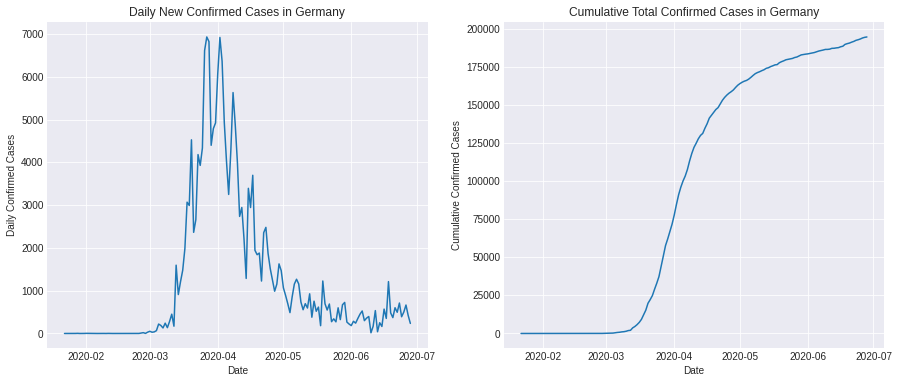

In [74]:
# re-run the same model through the class instance

ger_obj = KSegmentsModel(data, 'Germany')

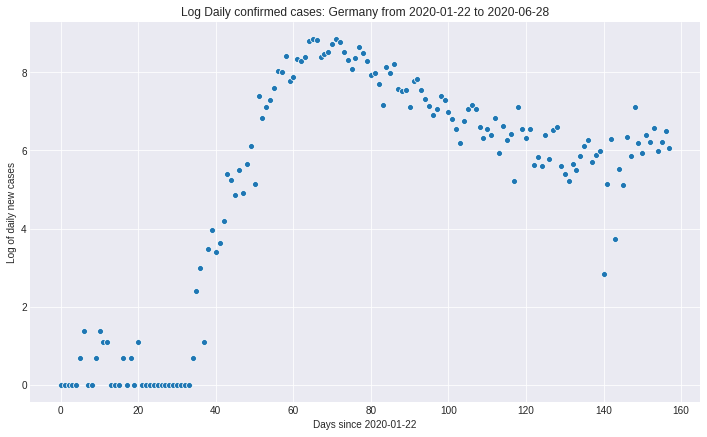

In [76]:
ger_obj.plot_log()

In [77]:
ger_obj.fit(k=4)

logp = -219.82, ||grad|| = 1.3128: 100%|██████████| 153/153 [00:00<00:00, 1146.12it/s] 
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [w4, b4, w3, b3, w2, b2, w1, b1, sigma]
>CompoundStep
>>Metropolis: [s3]
>>Metropolis: [s2]
>>Metropolis: [s1]
Sampling 2 chains: 100%|██████████| 42000/42000 [20:23<00:00, 34.33draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


<MultiTrace: 2 chains, 20000 iterations, 17 variables>

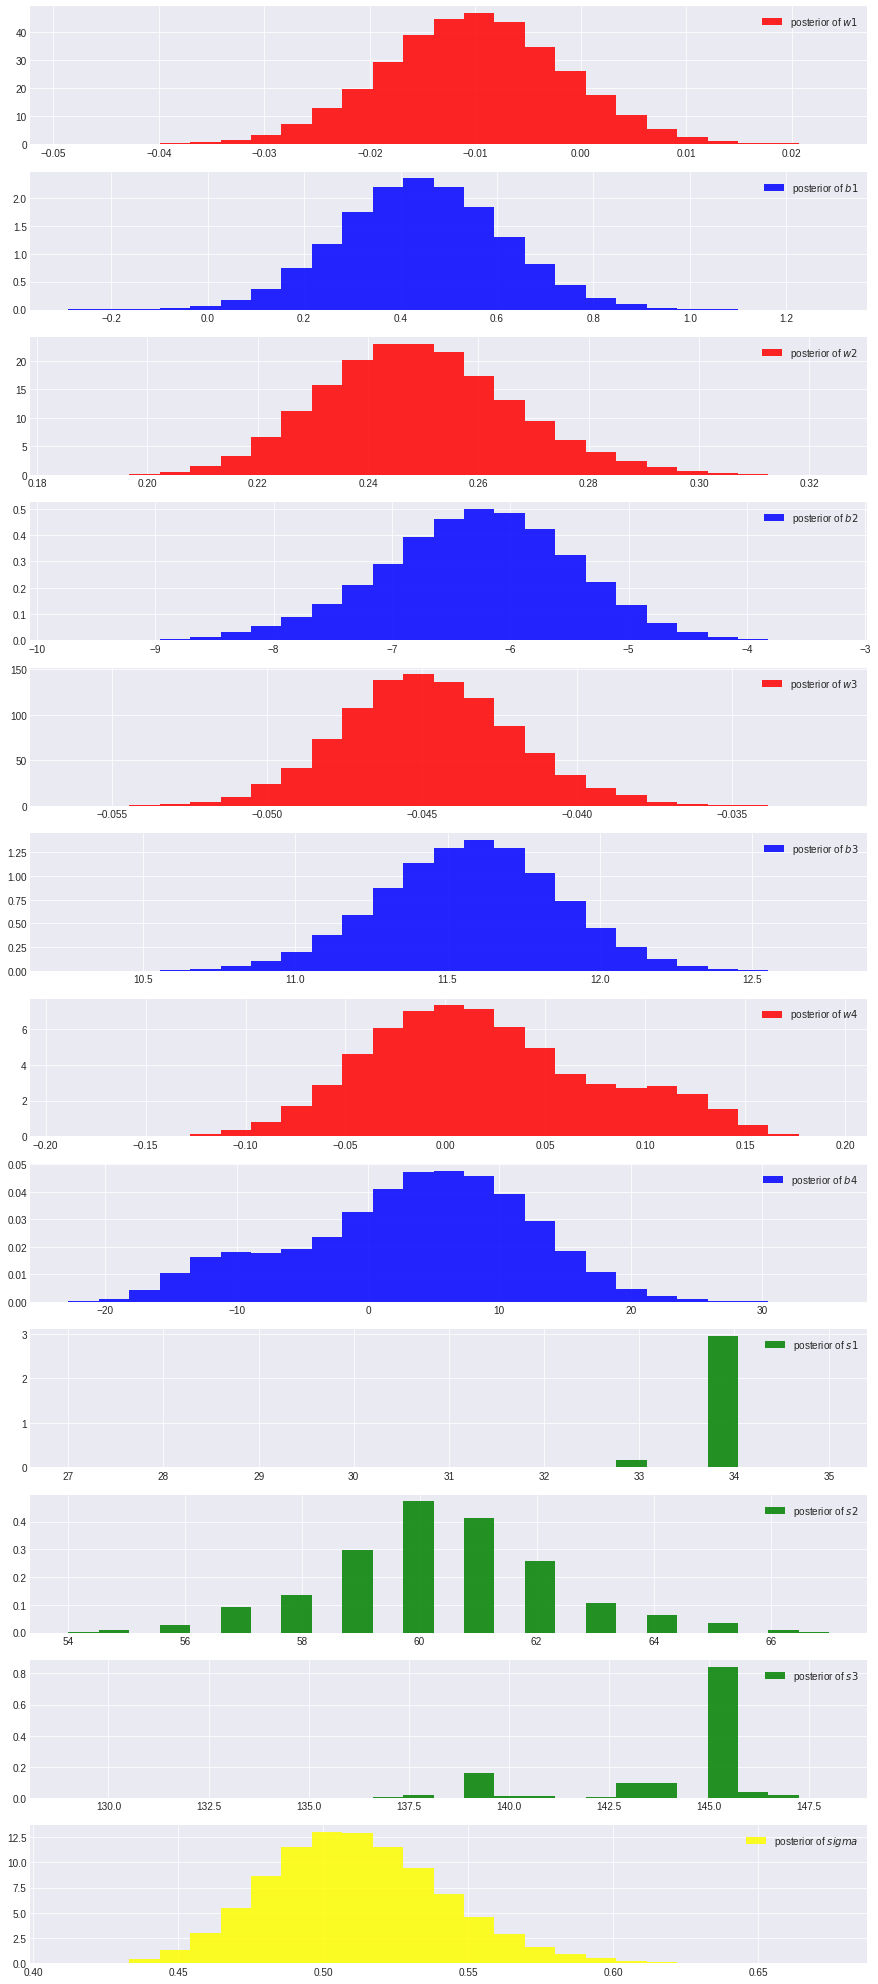

In [78]:
ger_obj.plot_posterior()

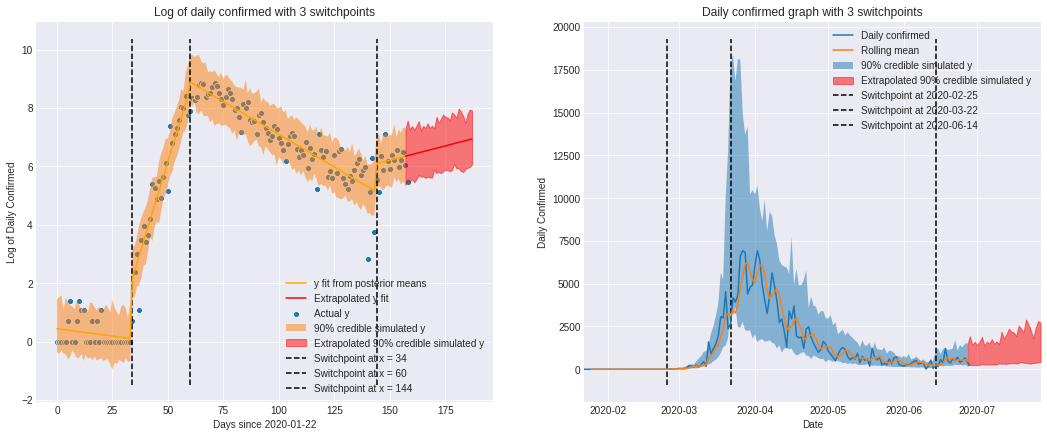

In [79]:
ger_obj.plot_extrapolation()

logp = -216.5, ||grad|| = 31.069: 100%|██████████| 128/128 [00:00<00:00, 1153.11it/s] 
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [w3, b3, w2, b2, w1, b1, sigma]
>CompoundStep
>>Metropolis: [s2]
>>Metropolis: [s1]
Sampling 2 chains: 100%|██████████| 42000/42000 [03:55<00:00, 178.03draws/s]
The number of effective samples is smaller than 10% for some parameters.


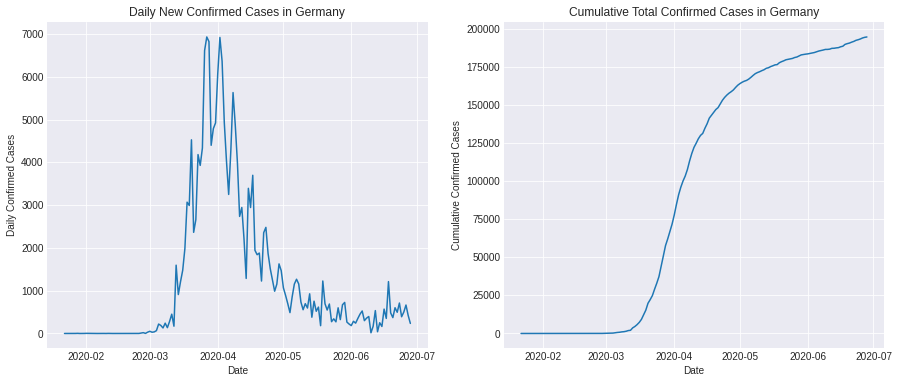

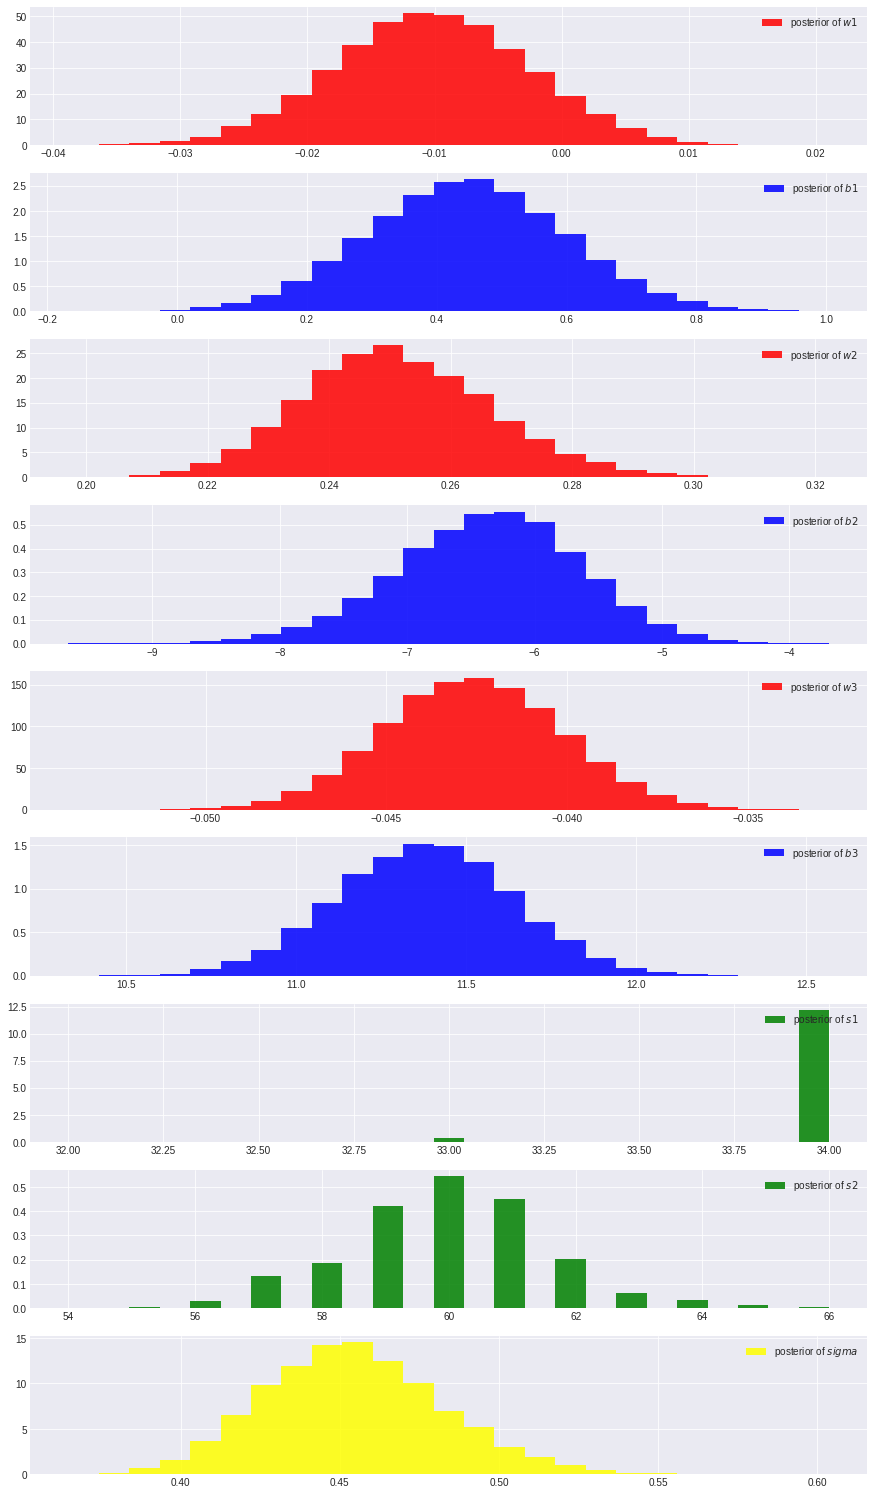

In [85]:
ger_obj = KSegmentsModel(data, 'Germany')
ger_obj.fit(k=3, start=0, end=140)
ger_obj.plot_posterior()

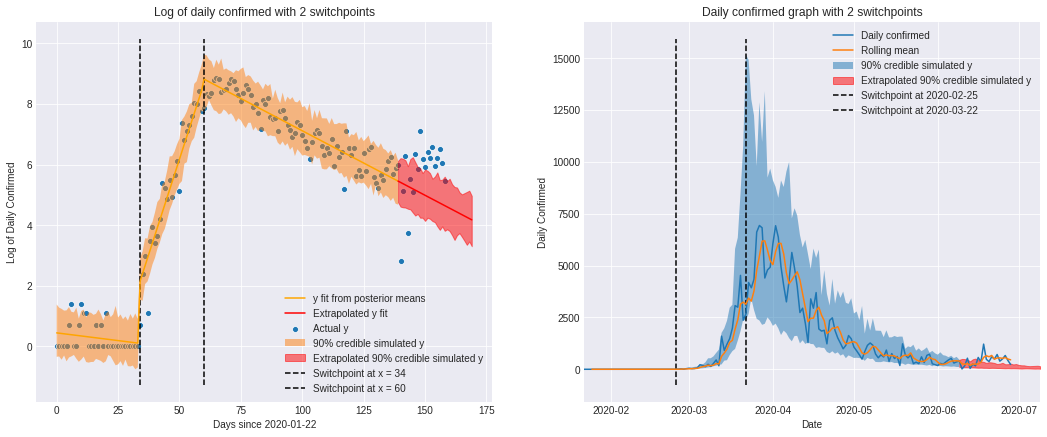

In [86]:
ger_obj.plot_extrapolation()

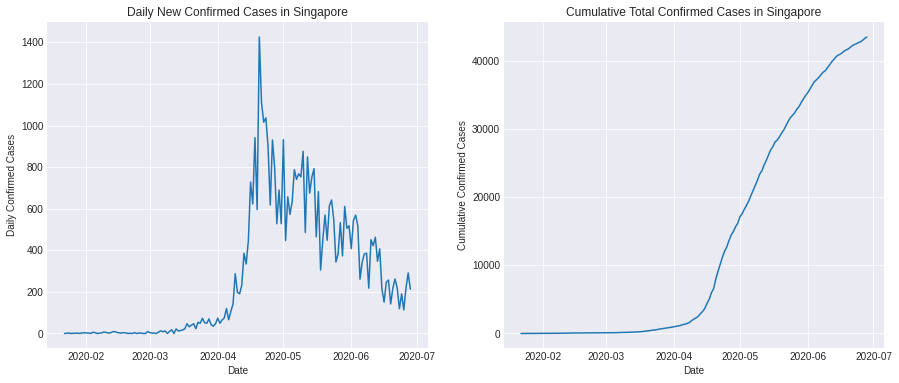

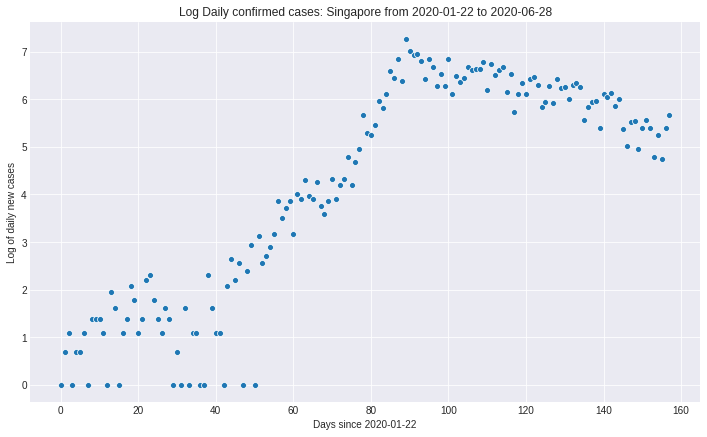

In [88]:
sg_obj = KSegmentsModel(data, 'Singapore')
sg_obj.plot_log()

logp = -174.08, ||grad|| = 8.352: 100%|██████████| 146/146 [00:00<00:00, 1311.47it/s] 
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [w3, b3, w2, b2, w1, b1, sigma]
>CompoundStep
>>Metropolis: [s2]
>>Metropolis: [s1]
Sampling 2 chains: 100%|██████████| 42000/42000 [04:00<00:00, 174.43draws/s]
There were 305 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5956418576357896, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


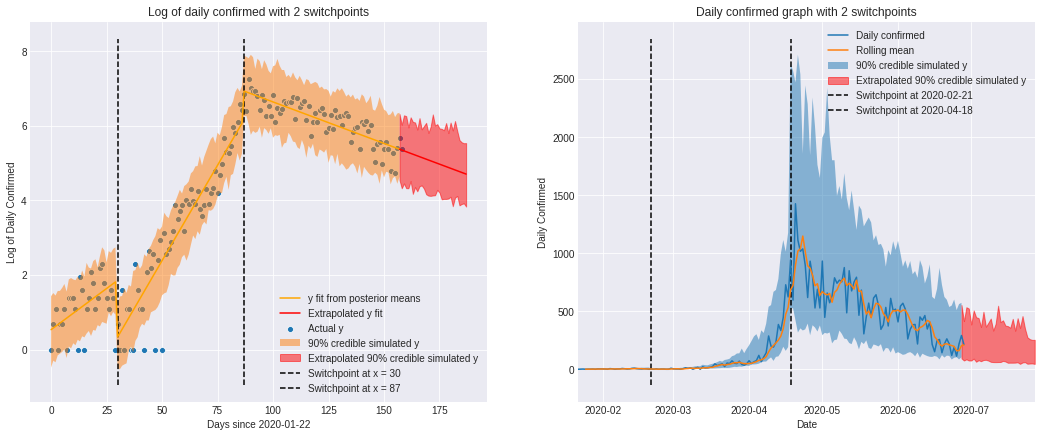

In [89]:
sg_obj.fit(k=3)
sg_obj.plot_extrapolation()